## 1. Feature Mapping using SIFT (Scale-Invariant Feature Transform)
SIFT detects and describes local features in images that are invariant to scale, rotation, and illumination changes

### Import Libraries and Setup

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import os
from glob import glob
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
OpenCV version: 4.12.0
TensorFlow version: 2.20.0


### Load and Display Sample Images

Looking for images in current directory...
No images found in current directory.
Please upload images or specify the correct path.

Successfully loaded images:
Image 1: assets/arceus.png - Shape: (225, 225)
Image 2: assets/pikachu.png - Shape: (224, 224)


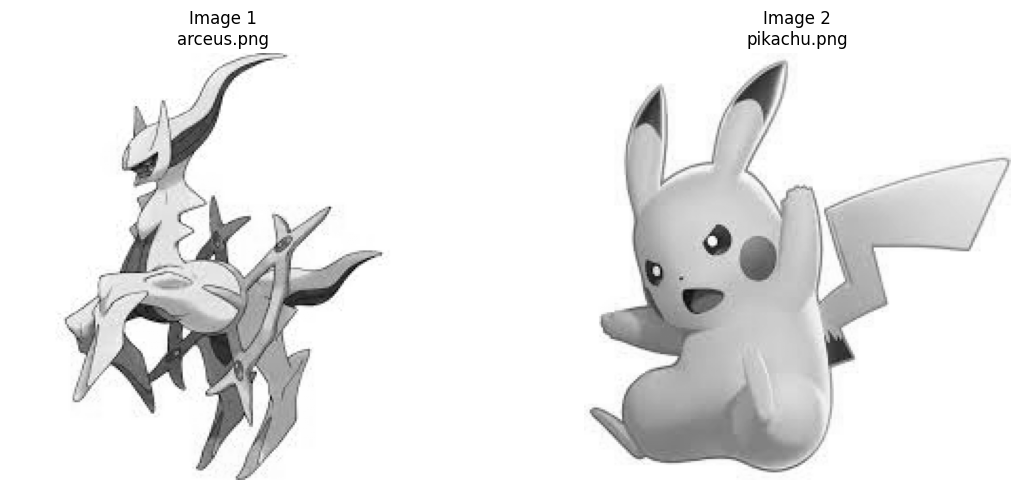

In [2]:
# Function to load images from directory or file
def load_image(image_path, color_mode='grayscale'):
    """
    Load image from file path
    color_mode: 'grayscale' or 'color'
    """
    if color_mode == 'grayscale':
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    return img

# List available images in current directory
print("Looking for images in current directory...")
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
available_images = []
for ext in image_extensions:
    available_images.extend(glob(ext))
    available_images.extend(glob(ext.upper()))

if len(available_images) > 0:
    print(f"Found {len(available_images)} images:")
    for i, img_path in enumerate(available_images[:10]):  # Show first 10
        print(f"  {i+1}. {img_path}")
else:
    print("No images found in current directory.")
    print("Please upload images or specify the correct path.")

# Load two images for SIFT demonstration
# Option 1: Specify your image paths directly
IMAGE_PATH_1 = "assets/arceus.png"  # Replace with your first image path
IMAGE_PATH_2 = "assets/pikachu.png"  # Replace with your second image path

# Option 2: Use first two available images if paths not specified
if len(available_images) >= 2:
    if not os.path.exists(IMAGE_PATH_1):
        IMAGE_PATH_1 = available_images[0]
    if not os.path.exists(IMAGE_PATH_2):
        IMAGE_PATH_2 = available_images[1]

# Try to load images
try:
    img1 = load_image(IMAGE_PATH_1, 'grayscale')
    img2 = load_image(IMAGE_PATH_2, 'grayscale')
    
    print(f"\nSuccessfully loaded images:")
    print(f"Image 1: {IMAGE_PATH_1} - Shape: {img1.shape}")
    print(f"Image 2: {IMAGE_PATH_2} - Shape: {img2.shape}")
    
    # Display images
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(f'Image 1\n{os.path.basename(IMAGE_PATH_1)}')
    axes[0].axis('off')
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(f'Image 2\n{os.path.basename(IMAGE_PATH_2)}')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"\nError loading images: {e}")
    print("\nPlease ensure you have uploaded images or update IMAGE_PATH_1 and IMAGE_PATH_2 variables.")
    print("You can upload images using the upload button in Jupyter or Colab.")

### SIFT Feature Detection and Matching

Number of keypoints in Image 1: 136
Number of keypoints in Image 2: 83
Descriptor shape for Image 1: (136, 128)
Descriptor shape for Image 2: (83, 128)
Each descriptor is a 128-dimensional vector


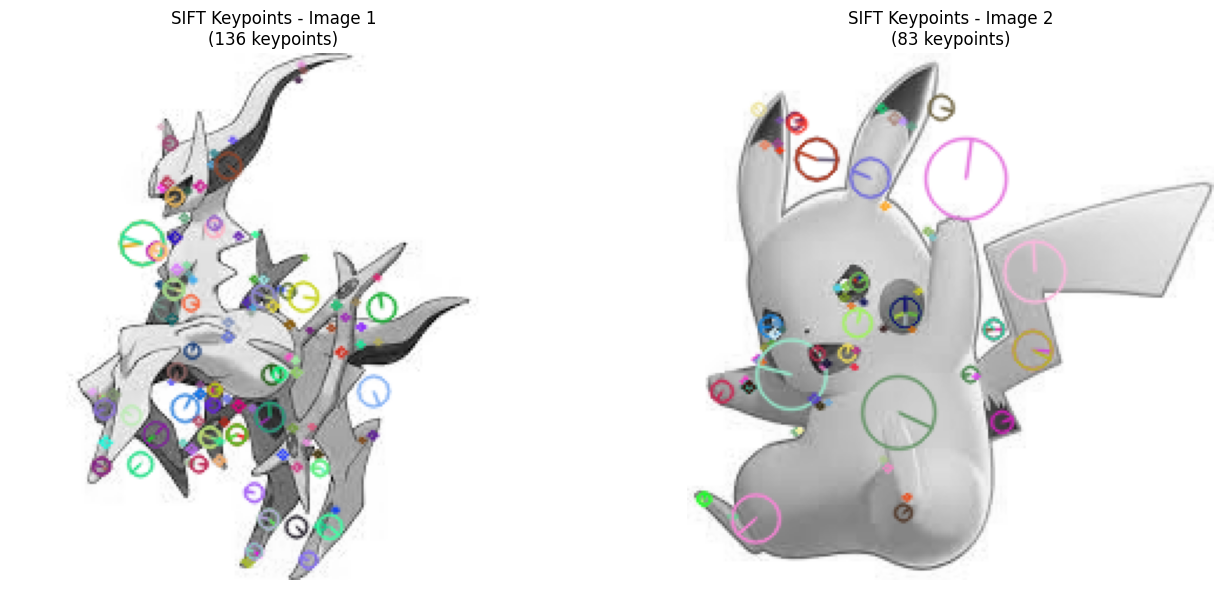


Keypoint Statistics:
Average keypoint response (Image 1): 0.0473
Average keypoint response (Image 2): 0.0401
Average keypoint size (Image 1): 5.21
Average keypoint size (Image 2): 6.82


In [3]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

print(f"Number of keypoints in Image 1: {len(keypoints1)}")
print(f"Number of keypoints in Image 2: {len(keypoints2)}")
print(f"Descriptor shape for Image 1: {descriptors1.shape}")
print(f"Descriptor shape for Image 2: {descriptors2.shape}")
print(f"Each descriptor is a 128-dimensional vector")

# Draw keypoints on images
img1_keypoints = cv2.drawKeypoints(img1, keypoints1, None, 
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_keypoints = cv2.drawKeypoints(img2, keypoints2, None, 
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display keypoints
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(cv2.cvtColor(img1_keypoints, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'SIFT Keypoints - Image 1\n({len(keypoints1)} keypoints)')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(img2_keypoints, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'SIFT Keypoints - Image 2\n({len(keypoints2)} keypoints)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Display keypoint statistics
print("\nKeypoint Statistics:")
print(f"Average keypoint response (Image 1): {np.mean([kp.response for kp in keypoints1]):.4f}")
print(f"Average keypoint response (Image 2): {np.mean([kp.response for kp in keypoints2]):.4f}")
print(f"Average keypoint size (Image 1): {np.mean([kp.size for kp in keypoints1]):.2f}")
print(f"Average keypoint size (Image 2): {np.mean([kp.size for kp in keypoints2]):.2f}")

### Feature Matching using BFMatcher

Number of matches found: 44
Best match distance: 232.51
Worst match distance: 433.97
Average match distance: 339.95
Median match distance: 353.59


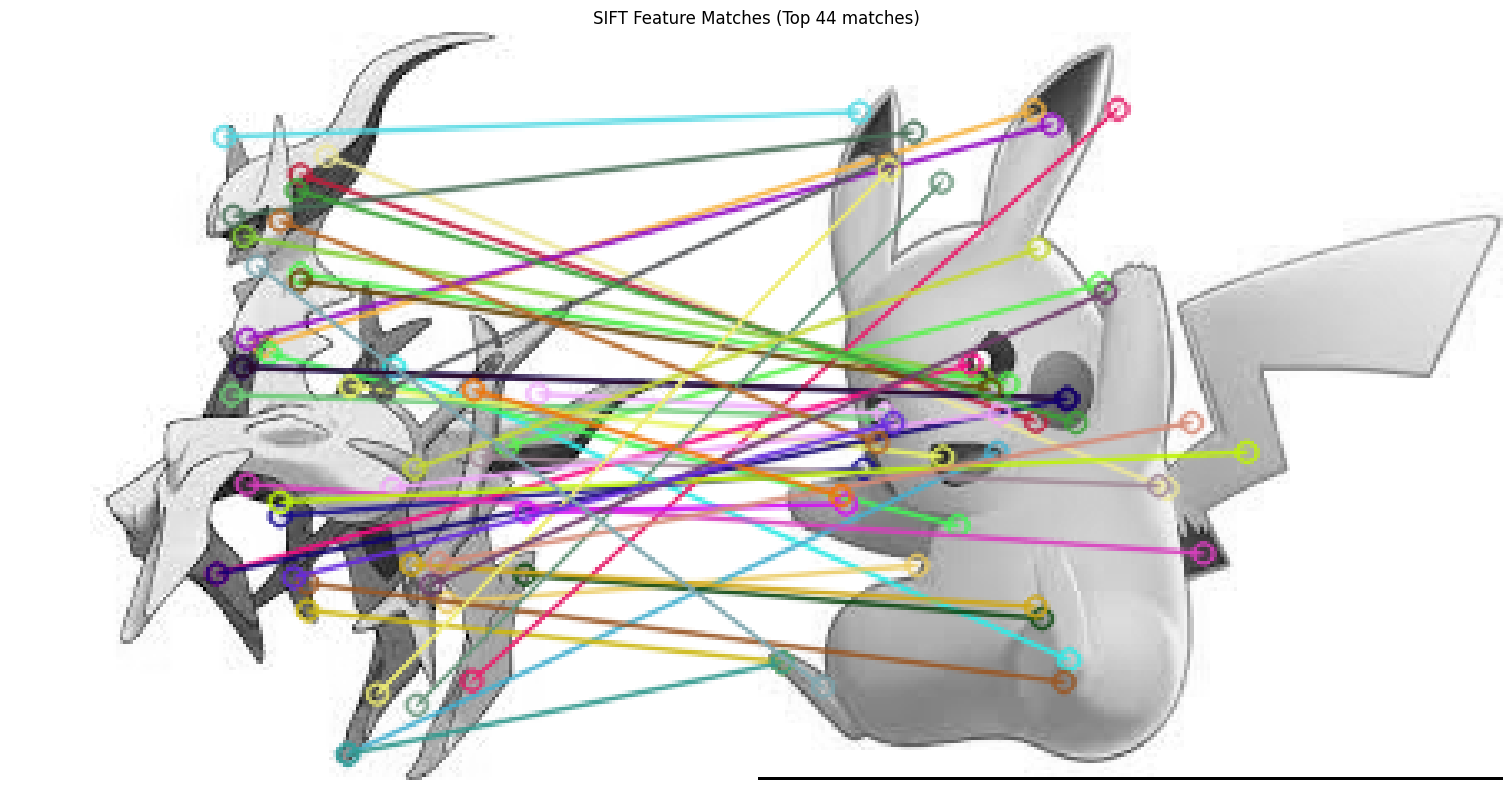

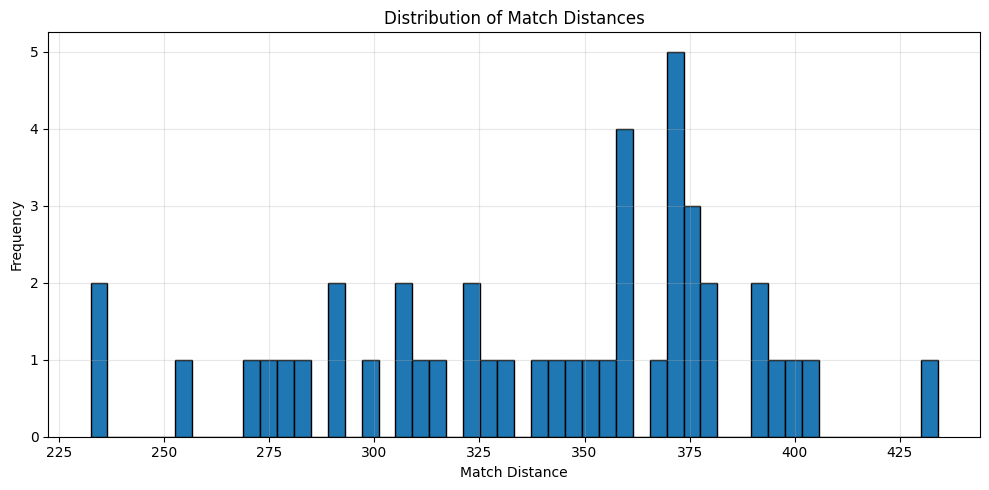

In [4]:
# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

print(f"Number of matches found: {len(matches)}")
print(f"Best match distance: {matches[0].distance:.2f}")
print(f"Worst match distance: {matches[-1].distance:.2f}")
print(f"Average match distance: {np.mean([m.distance for m in matches]):.2f}")
print(f"Median match distance: {np.median([m.distance for m in matches]):.2f}")

# Draw top matches
num_matches_to_show = min(50, len(matches))
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, 
                               matches[:num_matches_to_show], None, 
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matches
plt.figure(figsize=(16, 8))
plt.imshow(img_matches)
plt.title(f'SIFT Feature Matches (Top {num_matches_to_show} matches)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Analyze match quality
distances = [m.distance for m in matches]
plt.figure(figsize=(10, 5))
plt.hist(distances, bins=50, edgecolor='black')
plt.xlabel('Match Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Match Distances')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()